# ディリクレ過程混合ガウスモデルによるクラスタリングのJulia実装
---

# toy dataの生成

Ground Truthからtoy dataをサンプリングする

In [1]:
using PDMats
using Distributions
using LinearAlgebra
using Plots
using ProgressBars

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Warning: Module JSON with build ID 1290864591119004 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1017


In [2]:
μ1_gt = [0.; 5.]
μ2_gt = [-5.; 2.]
μ3_gt = [5.; -2.]
μ4_gt = [8.; -3.]
μ5_gt = [-4.; 6.]

Σ1_gt = [1. 0.; 0. 2.]
Σ2_gt = [.5 .75; .75 2.]
Σ3_gt = [.5 .1; .1 .5]
Σ4_gt = [.2 .2; .2 .5]
Σ5_gt = [2. 1.; 1. 2.5]

π_gt = [.3, .2, .15, .2, .15]

mixture_components = MvNormal[
    MvNormal(μ1_gt, Σ1_gt), 
    MvNormal(μ2_gt, Σ2_gt), 
    MvNormal(μ3_gt, Σ3_gt),
    MvNormal(μ4_gt, Σ4_gt),
    MvNormal(μ5_gt, Σ5_gt)
];

model_gt = MixtureModel(mixture_components, π_gt)

MixtureModel{MvNormal}(K = 5)
components[1] (prior = 0.3000): FullNormal(
dim: 2
μ: [0.0, 5.0]
Σ: [1.0 0.0; 0.0 2.0]
)

components[2] (prior = 0.2000): FullNormal(
dim: 2
μ: [-5.0, 2.0]
Σ: [0.5 0.75; 0.75 2.0]
)

components[3] (prior = 0.1500): FullNormal(
dim: 2
μ: [5.0, -2.0]
Σ: [0.5 0.1; 0.1 0.5]
)

components[4] (prior = 0.2000): FullNormal(
dim: 2
μ: [8.0, -3.0]
Σ: [0.2 0.2; 0.2 0.5]
)

components[5] (prior = 0.1500): FullNormal(
dim: 2
μ: [-4.0, 6.0]
Σ: [2.0 1.0; 1.0 2.5]
)



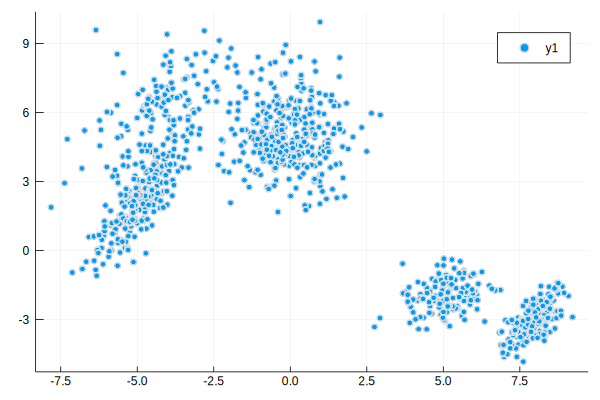

In [3]:
N = 1000

x_train = rand(model_gt, N)
scatter(x_train[1, :], x_train[2, :])

# DPGMMの構造体を作る

In [4]:
struct Gauss
    μ::Vector{Float64} # Mean Vector
    Λ::Matrix{Float64} # Precision Matrix
end

struct DPGMM
    D::Int
    K::Int
    mixing_coeff::Vector{Float64}
    components::Vector{Gauss}
end

DPGMMの可視化用の関数

In [5]:
function plot_contours(gmm::DPGMM)
    mvnormals = MvNormal[
        MvNormal(
            gmm.components[k].μ, 
            PDMat(Symmetric(inv(gmm.components[k].Λ)))
        ) for k in 1:gmm.K]
    
    for k in 1:gmm.K
        contour!(-10:0.05:10, -10:0.05:10, (x,y)->pdf(mvnormals[k], [x,y]), color=k, colorbar=:none)
    end
end

plot_contours (generic function with 1 method)

In [6]:
gaussians_gt = Gauss[
    Gauss(μ1_gt, inv(Σ1_gt)), 
    Gauss(μ2_gt, inv(Σ2_gt)), 
    Gauss(μ3_gt, inv(Σ3_gt)),
    Gauss(μ4_gt, inv(Σ4_gt)),
    Gauss(μ5_gt, inv(Σ5_gt))
];

gmm_gt = DPGMM(2, 5, π_gt, gaussians_gt)

DPGMM(2, 5, [0.3, 0.2, 0.15, 0.2, 0.15], Gauss[Gauss([0.0, 5.0], [1.0 0.0; 0.0 0.5]), Gauss([-5.0, 2.0], [4.571428571428571 -1.7142857142857142; -1.7142857142857144 1.1428571428571428]), Gauss([5.0, -2.0], [2.0833333333333335 -0.41666666666666674; -0.41666666666666674 2.0833333333333335]), Gauss([8.0, -3.0], [8.333333333333334 -3.3333333333333335; -3.3333333333333335 3.3333333333333335]), Gauss([-4.0, 6.0], [0.625 -0.25; -0.25 0.5])])

Ground Truthのプロット

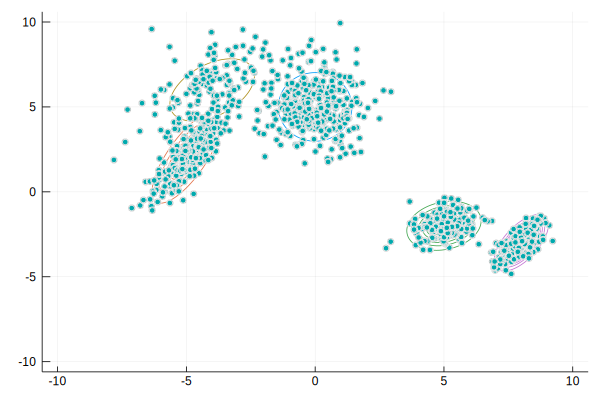

In [7]:
plt = plot()
plot_contours(gmm_gt)
scatter!(x_train[1, :], x_train[2, :], legend=:none)

## ハイパーパラメタの準備

In [8]:
# Number of Classes
K = 1;

# Number of Dimensions
D = 2;

In [9]:
α = 10.0

α0 = ones(K) * α / K
μ0 = zeros(D)
β0 = 1e-3
ν0 = convert(Float64, D)
W0 = Matrix{Float64}(I, D, D) * 5.0

2×2 Array{Float64,2}:
 5.0  0.0
 0.0  5.0

In [10]:
# Parameters of Student's t-dist
μ_s = μ0
Λ_s = (1 - D + ν0) * β0 / (1 + β0) * W0
ν_s = 1 - D + ν0

1.0

## 潜在変数の準備

潜在変数の初期値は事前分布からサンプリングする

In [11]:
mixing_coeff = rand(Dirichlet(α0))

μk = zeros(K, D)
Λk = zeros(K, D, D)

for k in 1:K
    Λk[k, :, :] = rand(Wishart(ν0, W0))
    μk[k, :] = rand(MvNormal(μ0, PDMat(Symmetric(inv(β0 * Λk[k, :, :])))))
end

gaussians = Gauss[Gauss(μk[k, :], Λk[k, :, :]) for k in 1:K]

1-element Array{Gauss,1}:
 Gauss([16.64461721247163, -7.3290740500053895], [4.0163358060189305 -2.2064800529147965; -2.2064800529147965 5.503413115825852])

In [12]:
gmm = DPGMM(D, K, mixing_coeff, gaussians)
hidden_state = rand(Categorical(gmm.mixing_coeff), N);

データとクラスタの初期割当をプロット

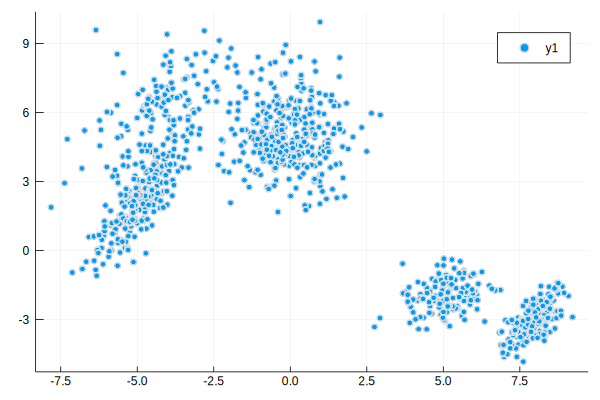

In [13]:
plt = plot()
scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state)

# ギプスサンプリングの実装

## DPGMMの対数同時確率の計算

事後確率最大化に使う

In [14]:
function compute_log_ewens(gmm::DPGMM, hidden_state::Array{Int64, 1})
    
    log_lik = 0.0
    
    log_lik += gmm.K * log(α)
    
    state_ids = Array{Int64,1}(1:gmm.K)
    n_i = [count(x -> x == i, hidden_state) for i in state_ids]
    
    for k in 1:gmm.K
        log_lik += sum(log.(collect(1:n_i[k])))
    end
    
    log_AF = sum(log.(α .+ collect(0:N-1)))
    log_lik -= log_AF
    
    log_lik -= sum(log.(collect(1:gmm.K)))
    
    return log_lik
end

function compute_log_likelihood(gmm::DPGMM, x_train::Array{Float64}, hidden_state::Array{Int64, 1})
    
    log_lik = 0.0
    
    mvnormals = MvNormal[
        MvNormal(
            gmm.components[k].μ, 
            PDMat(Symmetric(inv(gmm.components[k].Λ)))
        ) for k in 1:gmm.K
    ]
    
    for n in 1:N
        log_lik += logpdf(mvnormals[hidden_state[n]], x_train[:, n])
        # log_lik += logpdf(Categorical(gmm.mixing_coeff), hidden_state[hidden_state[n]])
    end

    # Log likelihood of Normal-Wishart
    for k in 1:gmm.K
        log_lik += logpdf(MvNormal(μ0, PDMat(Symmetric(inv(gmm.components[k].Λ)))), gmm.components[k].μ)
        log_lik += logpdf(Wishart(ν0, W0), gmm.components[k].Λ)
    end

    log_lik += compute_log_ewens(gmm, hidden_state)
    # log_lik += logpdf(Dirichlet(α0), gmm.mixing_coeff)
    
    return log_lik
end

compute_log_likelihood (generic function with 1 method)

### クラスタ割り当てのサンプリング

In [15]:
function compute_likelihood(dists::Array{T}, x_train::Array{Float64}) where T <: Distribution
    # Number of dists
    K = size(dists, 1)
    # Number of data
    N = size(x_train, 2)
    # temporary variable
    p_xi = zeros(N, K)
    
    for k in 1:K
        p_xi[:, k] = pdf(dists[k], x_train)
    end
    
    return p_xi
end

function sample_hidden_state(gmm::DPGMM, x_train::Array{Float64})
    # Number of data
    N = size(x_train, 2)
    
    for n in 1:N
        state_ids = Array{Int64,1}(1:gmm.K)
        m = [count(x -> x == i, hidden_state) for i in state_ids]
        m[hidden_state[n]] -= 1

        if m[hidden_state[n]] == 0
            ## Remove empty category

            ### 消されたクラスタより後ろの番号のクラスタについて，番号をつめる
            hidden_state[hidden_state .> hidden_state[n]] .-= 1

            ### 消されたクラスタを削除する
            m = m[state_ids .!= hidden_state[n]]
            remained_components = [gmm.components[k] for k in 1:gmm.K if k != hidden_state[n]]

            gmm = DPGMM(gmm.D, gmm.K-1, gmm.mixing_coeff, remained_components)
        end

        new_mixing_coeff = [m; α]
        new_mixing_coeff = new_mixing_coeff ./ (sum(new_mixing_coeff) - 1 + α)

        # Compute likelihoods
        mvnormals = [MvNormal(
                gmm.components[k].μ, 
                PDMat(Symmetric(inv(gmm.components[k].Λ)))
            ) for k in 1:gmm.K]
        mvnormals = [mvnormals; MvTDist(ν_s, μ_s, Λ_s)] # Add dist for new category
        
        likelihood = zeros(gmm.K+1)
        for k in 1:(gmm.K+1)
            likelihood[k] = pdf(mvnormals[k], x_train[:, n])
        end
        new_mixing_coeff = new_mixing_coeff .* likelihood
        new_mixing_coeff = new_mixing_coeff ./ sum(new_mixing_coeff)
        
        # Resample hidden state
        hidden_state[n] = rand(Categorical(new_mixing_coeff))

        if hidden_state[n] == gmm.K+1
            # Add new category
            Λ_new = rand(Wishart(ν0, W0))
            μ_new = rand(MvNormal(μ0, PDMat(Symmetric(inv(β0 * Λ_new)))))

            new_components = Gauss[gmm.components; Gauss(μ_new, Λ_new)]

            gmm = DPGMM(gmm.D, gmm.K+1, gmm.mixing_coeff, new_components)
        else
            gmm = DPGMM(gmm.D, gmm.K, gmm.mixing_coeff, gmm.components)
        end
    end
    
    return hidden_state, gmm
end

sample_hidden_state (generic function with 1 method)

### 混合係数 $\pi$ のサンプリング

In [16]:
function sample_mixing_coeff(gmm::DPGMM, hidden_state::Array{Int64,1})
    state_ids = Array{Int64,1}(1:gmm.K)
    m = [count(x -> x == i, hidden_state) for i in state_ids]
    
    α_post = ones(gmm.K) / α + m
    new_mixing_coeff = rand(Dirichlet(α_post))
    
    return DPGMM(gmm.D, gmm.K, new_mixing_coeff, gmm.components)
end

sample_mixing_coeff (generic function with 1 method)

### ガウス分布のパラメタ $\mu_k$ と $\Lambda_k$ のサンプリング

In [17]:
function sample_gauss(gmm::DPGMM, x_train::Array{Float64}, hidden_state::Array{Int64,1})
    new_μk = zeros(gmm.K, gmm.D)
    new_Λk = zeros(gmm.K, gmm.D, gmm.D)

    # temporary variables
    state_ids = Array{Int64,1}(1:gmm.K)
    m = [count(x -> x == i, hidden_state) for i in state_ids]

    for k in 1:gmm.K
        # Get data in the k-th class
        x_k = x_train[:, hidden_state .== k]
        # Compute the covariance matrix of the k-th class
        S_k = x_k * x_k'

        # Compute parameters of posterior distributions
        β_post = β0 + m[k]
        μ_post = (sum(x_k, dims=2) + β0 * μ0) / β_post
        μ_post = μ_post[:, 1]

        ν_post = ν0 + m[k]
        W_post_inv = S_k + β0 * μ0 * μ0' - β_post * μ_post * μ_post' + inv(W0)
        W_post = PDMat(Symmetric(inv(W_post_inv)))
        
        # Sample parameters from posterior distributions
        new_Λk[k, :, :] = rand(Wishart(ν_post, W_post))
        new_μk[k, :] = rand(MvNormal(μ_post, PDMat(Symmetric(inv(β_post * new_Λk[k, :, :])))))
    end
    
    new_components = Gauss[Gauss(new_μk[k, :], new_Λk[k, :, :]) for k in 1:gmm.K]
    
    return DPGMM(gmm.D, gmm.K, gmm.mixing_coeff, new_components)
end

sample_gauss (generic function with 1 method)

# ギプスサンプリングの実行とアニメーションの生成

アニメーション生成の参考

https://qiita.com/Lirimy/items/8976bb4dcf5febad178e

In [18]:
# 対数同時確率を最大にするパラメタとクラス割当て，そのときの対数事後確率を保存する
gmm_max = deepcopy(gmm)
hidden_state_max = copy(hidden_state)
loglik_max = compute_log_likelihood(gmm, x_train, hidden_state)

-1.2018555290217667e6

In [19]:
loglik_list = Array{Float64, 1}()

0-element Array{Float64,1}

In [20]:
anim = Animation()

# 初期状態のプロット
plt = scatter(x_train[1, :], x_train[2, :], markercolor=hidden_state, legend=:none)
plot_contours(gmm)
title!("Iteration: 0")
frame(anim, plt)

for iter in tqdm(1:1000)
    # クラスタ割り当てのサンプリング
    hidden_state, gmm = sample_hidden_state(gmm, x_train)
    # 混合係数のサンプリング
    gmm = sample_mixing_coeff(gmm, hidden_state)
    # ガウス分布のパラメタのサンプリング
    gmm = sample_gauss(gmm, x_train, hidden_state)
    
    loglik = compute_log_likelihood(gmm, x_train, hidden_state)
    
    if loglik > loglik_max
        gmm_max = deepcopy(gmm)
        hidden_state_max = copy(hidden_state)
        loglik_max = compute_log_likelihood(gmm, x_train, hidden_state)
    end
    
    push!(loglik_list, loglik)
    
    # ギプスサンプリングの現在の状態をプロット
    if iter % 50 == 0
        plt = plot()
        scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state, legend=:none)
        plot_contours(gmm)
        title!("Iteration: $iter")
        frame(anim, plt)
    end
end

gif(anim, "gs_dpgmm.gif", fps=2);

100.00%┣█████████████████████████████████████████████████████████▉┫ 1000/1000 01:42<00:00, 9.80 it/s]┫ 2/1000 00:06<01:46:04, 0.16 it/s]5/1000 00:07<29:39, 0.56 it/s]7/1000 00:08<20:43, 0.80 it/s]8/1000 00:08<18:07, 0.91 it/s]13/1000 00:09<11:40, 1.41 it/s]18/1000 00:09<08:54, 1.84 it/s]19/1000 00:09<08:32, 1.92 it/s]23/1000 00:10<07:18, 2.23 it/s]25/1000 00:10<06:51, 2.37 it/s]26/1000 00:10<06:39, 2.44 it/s]30/1000 00:11<05:57, 2.72 it/s]31/1000 00:11<05:47, 2.79 it/s]34/1000 00:11<05:24, 2.99 it/s]35/1000 00:11<05:16, 3.05 it/s]37/1000 00:11<05:03, 3.18 it/s]38/1000 00:11<04:57, 3.24 it/s]40/1000 00:12<04:46, 3.35 it/s]42/1000 00:12<04:36, 3.47 it/s]┫ 44/1000 00:12<04:27, 3.58 it/s]┫ 52/1000 00:17<05:17, 2.99 it/s]55/1000 00:17<05:03, 3.12 it/s]57/1000 00:18<04:55, 3.20 it/s]┫ 58/1000 00:18<04:50, 3.25 it/s]61/1000 00:18<04:39, 3.36 it/s]66/1000 00:18<04:23, 3.56 it/s]70/1000 00:19<04:10, 3.72 it/s]72/1000 00:19<04:05, 3.79 it/s]76/1000 00:19<03:55, 3.93 it/s]78/1000 00:19<03:50, 4.0

┌ Info: Saved animation to 
│   fn = C:\Users\chikuwa\workspace\julia-work\gs_dpgmm.gif
└ @ Plots C:\Users\chikuwa\.julia\packages\Plots\Ih71u\src\animation.jl:95


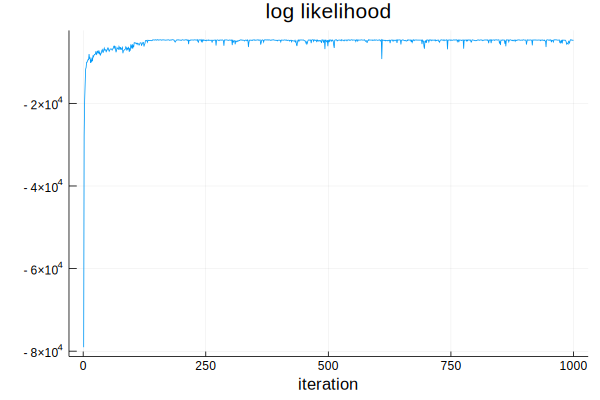

In [21]:
plot(loglik_list, legend=:none, title="log likelihood", xlabel="iteration")

サンプリングの過程

![gs_dpgmm_result](gs_dpgmm.gif)

結果

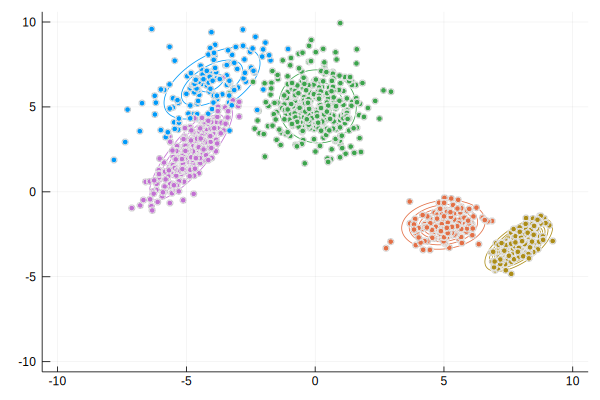

In [23]:
plt = plot()
plot_contours(gmm_max)
scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state_max, legend=:none)